# Ruble Volatility Project — Part 3: Time Series GARCH Modeling

This notebook continues the Ruble Volatility Project...

In this notebook ...

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model


from sklearn.metrics import mean_squared_error

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore")
from stargazer.stargazer import Stargazer




While ARIMA models, as applied in ([03_Time_Series_ARIMA_Modeling.ipynb](03_Time_Series_ARIMA_Modeling.ipynb)), are effective for forecasting the mean level of a time series, they assume that the variance of the residuals is constant over time (homoskedasticity). However, in financial and exchange rate data, this assumption rarely holds.  

Exchange rates often exhibit time-varying volatility (heteroskedasticity), where periods of relative calm are followed by clusters of high uncertainty or crisis-driven spikes. This phenomenon is known as **volatility clustering**.  

To capture this behavior, in this notebook, I now turn to the GARCH (Generalized AutoRegressive Conditional Heteroskedasticity) framework.  Unlike ARIMA, which models the mean dynamics, GARCH explicitly models the conditional variance, making it a powerful tool for analyzing and forecasting exchange rate volatility.  

### I. Loading data

In [66]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction/data/Full_Ruble_Monthly_Data.csv")
# Ensure proper datetime index at month-end
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data.set_index('date', inplace=True)
# Normalize to month-end timestamps for consistent plotting and modeling
data.index = data.index.to_period('M').to_timestamp('M')

data.tail()

,old_RUB,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt,denomination,RUB
date,,,,,,,,,,,,
2025-04-30,83.243645,2025.0,4.0,14260.0,63.37,8.2,3.300000e+09,8.14,-0.213785,0.0,post,83.243645
2025-05-31,80.237650,2025.0,5.0,14260.0,64.32,8.2,3.300000e+09,8.14,-0.178412,0.0,post,80.237650
2025-06-30,78.677635,2025.0,6.0,14260.0,68.15,8.2,3.300000e+09,8.14,-0.004909,0.0,post,78.677635
2025-07-31,78.850139,2025.0,7.0,14260.0,73.43,8.2,3.300000e+09,8.14,0.101659,0.0,post,78.850139
2025-08-31,80.013656,2025.0,8.0,14260.0,67.83,8.2,3.300000e+09,8.14,0.034674,0.0,post,80.013656


In [67]:
data.size

4776

### II. Stationarity & Returns

To make your GARCH model as close to actual volatility as possible, I will use returns, not raw prices.
Using returns allows to capture relative changes, stabilize variance, and better model volatility dynamics.  

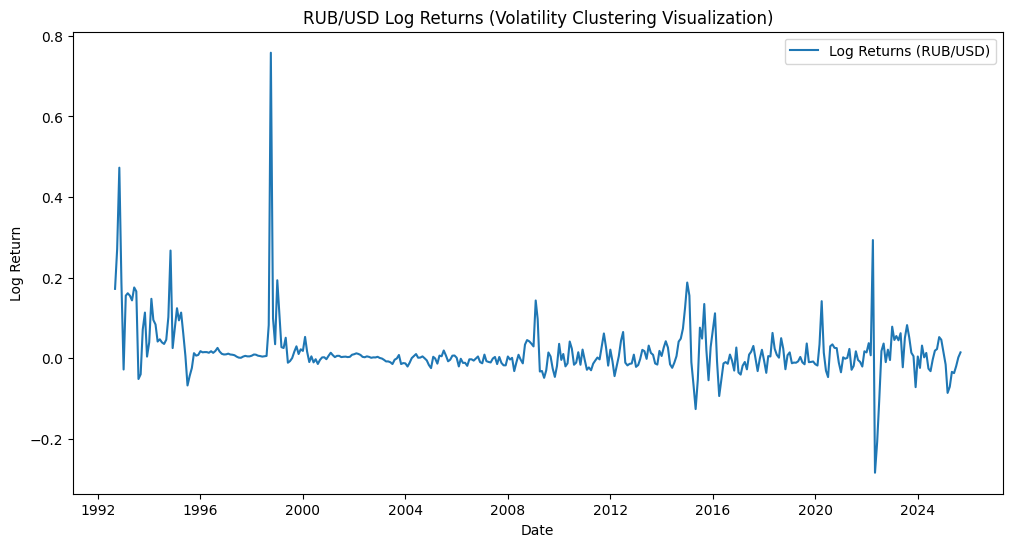

In [68]:
data["log_return"] = np.log(data["RUB"] / data["RUB"].shift(1))

plt.figure(figsize=(12,6))
plt.plot(data.index, data["log_return"], label="Log Returns (RUB/USD)")
plt.title("RUB/USD Log Returns (Volatility Clustering Visualization)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.show()

Based on this volatility plot, there is strong evidence of volatility clustering in RUB/USD returns, which confirms that ARIMA (SARIMAX) alone isn’t enough, and a GARCH-type model is needed to capture this behavior.

### III. ARCH test

Before fitting a GARCH model, it’s essential to check whether the residuals from our baseline forecasting model (SARIMAX) exhibit signs of time-varying volatility — a key condition for GARCH-type models.

Even with volatile exogenous variables (like Brent oil and GDP), the SARIMAX residuals should ideally have constant variance.
The ARCH test confirms whether volatility clustering remains unexplained — justifying the use of a GARCH model. 

I apply the ARCH LM test to the residuals of the chosen SARIMAX Model 7 used in ([03_Time_Series_ARIMA_Modeling.ipynb.ipynb](03_Time_Series_ARIMA_Modeling.ipynb.ipynb)). This test statistically evaluates whether past squared residuals help predict current residual variance.

In [69]:
data['Brent_price_lag1'] = data['Brent_price'].shift(1)
data['Brent_price_lag2'] = data['Brent_price'].shift(2)
data['Brent_price_lag3'] = data['Brent_price'].shift(3)
data['GDP_per_capita_lag12'] = data['GDP_per_capita'].shift(12)
data_lagged = data.dropna()
data_lagged.size

6562

In [70]:
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita_lag12']


data['Brent_price_lag1'] = data['Brent_price'].shift(1)
data['GDP_per_capita_lag12'] = data['GDP_per_capita'].shift(12)


data_model = data.dropna(subset=[target] + exog_vars).copy()
y = data_model[target]
X = data_model[exog_vars]

# fit SARIMAX Model 7 
model7 = SARIMAX(y, exog=X, order=(2,1,2), enforce_stationarity=False, enforce_invertibility=False)
result7 = model7.fit(disp=False)

resid7 = result7.resid


for lags in [6, 12, 24]:
    arch_test = het_arch(resid7, nlags=lags)
    print(f"ARCH Test (lags={lags}):")
    print(f"  LM Stat: {arch_test[0]:.2f}, p-value: {arch_test[1]:.4f}")
    print(f"  F Stat:  {arch_test[2]:.2f}, p-value: {arch_test[3]:.4f}")
    print("-"*50)

ARCH Test (lags=6):
  LM Stat: 162.78, p-value: 0.0000
  F Stat:  46.59, p-value: 0.0000
--------------------------------------------------
ARCH Test (lags=12):
  LM Stat: 164.80, p-value: 0.0000
  F Stat:  23.70, p-value: 0.0000
--------------------------------------------------
ARCH Test (lags=24):
  LM Stat: 166.73, p-value: 0.0000
  F Stat:  11.99, p-value: 0.0000
--------------------------------------------------


The test results for all lags (6, 12, 24) had very small p-values (0.0000). This means the test found clear signs of volatility clustering — periods when errors are small or large for many months in a row.

Because of this, it makes sense to try a GARCH model, which is designed to handle this kind of time-varying volatility better than a regular SARIMAX.

### IV. Fit GARCH Models

In [71]:
returns = data["log_return"].dropna()

#### 1. ARCH (1)

In [72]:
# 1. ARCH(1)
arch1 = arch_model(returns, vol='ARCH', p=1, q=0, dist='normal')
arch1_fit = arch1.fit(disp='off')
print("ARCH(1) Results:")
print(arch1_fit.summary())

ARCH(1) Results:
                      Constant Mean - ARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                671.934
Distribution:                  Normal   AIC:                          -1337.87
Method:            Maximum Likelihood   BIC:                          -1325.92
                                        No. Observations:                  397
Date:                Sun, Oct 05 2025   Df Residuals:                      396
Time:                        18:00:03   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.2113e-03  3.293e-03  

#### 2. GARCH (1,1)

In [73]:
# 2. GARCH(1,1) - benchmark
garch11 = arch_model(returns, vol='GARCH', p=1, q=1, dist='normal')
garch11_fit = garch11.fit(disp='off')
print("GARCH(1,1) Results:")
print(garch11_fit.summary())


GARCH(1,1) Results:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                615.874
Distribution:                  Normal   AIC:                          -1223.75
Method:            Maximum Likelihood   BIC:                          -1207.81
                                        No. Observations:                  397
Date:                Sun, Oct 05 2025   Df Residuals:                      396
Time:                        18:00:03   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.5469e-05  6.079e-0

#### 3. EGARCH (1,1)

In [74]:
# 3. EGARCH(1,1)
egarch = arch_model(returns, vol='EGARCH', p=1, q=1, dist='normal')
egarch_fit = egarch.fit(disp='off')
print("EGARCH(1,1) Results:")
print(egarch_fit.summary())

EGARCH(1,1) Results:
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                765.180
Distribution:                  Normal   AIC:                          -1522.36
Method:            Maximum Likelihood   BIC:                          -1506.42
                                        No. Observations:                  397
Date:                Sun, Oct 05 2025   Df Residuals:                      396
Time:                        18:00:03   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.7822e-03  2.436e-

#### 4. GJR-GARCH (1,1)

In [75]:
# 4. GJR-GARCH(1,1) 
gjr = arch_model(returns, vol='GARCH', p=1, o=1, q=1, dist='normal')
gjr_fit = gjr.fit(disp='off')
print("GJR-GARCH(1,1) Results:")
print(gjr_fit.summary())

GJR-GARCH(1,1) Results:
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                721.393
Distribution:                  Normal   AIC:                          -1432.79
Method:            Maximum Likelihood   BIC:                          -1412.87
                                        No. Observations:                  397
Date:                Sun, Oct 05 2025   Df Residuals:                      396
Time:                        18:00:03   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.0634e-03  1.71

#### GARCH Family Model Results

In [76]:
model_list = [arch1_fit, garch11_fit, egarch_fit, gjr_fit]
model_names = ["ARCH(1)", "GARCH(1,1)", "EGARCH(1,1)", "GJR-GARCH(1,1)"]

# AIC & BIC 
print("Model\t\tAIC\t\tBIC")
for name, fit in zip(model_names, model_list):
    print(f"{name:12s}\t{fit.aic:.2f}\t{fit.bic:.2f}")

# coeffs
param_dict = {}
for name, fit in zip(model_names, model_list):
    params = fit.params
    param_dict[name] = params

param_df = pd.DataFrame(param_dict).T
print("\nModel coefficients comparison:")
print(param_df)

Model		AIC		BIC
ARCH(1)     	-1337.87	-1325.92
GARCH(1,1)  	-1223.75	-1207.81
EGARCH(1,1) 	-1522.36	-1506.42
GJR-GARCH(1,1)	-1432.79	-1412.87

Model coefficients comparison:
                alpha[1]   beta[1]  gamma[1]        mu     omega
ARCH(1)         1.000000       NaN       NaN -0.001211  0.000822
GARCH(1,1)      0.345302  0.409186       NaN -0.000015  0.001144
EGARCH(1,1)     1.183782  0.870082       NaN -0.001782 -0.734629
GJR-GARCH(1,1)  0.846794  0.318724  -0.77968 -0.001063  0.000339


* ω (omega): long-run variance constant.
* α (alpha): short-term shock effect.
* β (beta): persistence of volatility.

* For GJR/EGARCH → you’ll also see asymmetry terms (γ or leverage effect).
* If α + β ≈ 1 → very persistent volatility (common in FX data).

Model comparison:
- ARCH(1): Unstable, with α ≈ 1.0, not suitable for long-run volatility modeling.  
- GARCH(1,1): Captures persistence (α + β ≈ 0.73) but misses asymmetry.  
- EGARCH(1,1): Best fit, captures volatility clustering and asymmetry (leverage effects).  
- GJR-GARCH(1,1): Also shows asymmetry, confirming that negative shocks increase volatility more than positive shocks.  

RUB/USD volatility is highly persistent and asymmetric. Crisis events (sanctions, political shocks) cause stronger volatility spikes than positive shocks. Based on AIC/BIC, EGARCH(1,1) provides the best fit, making it the preferred model.

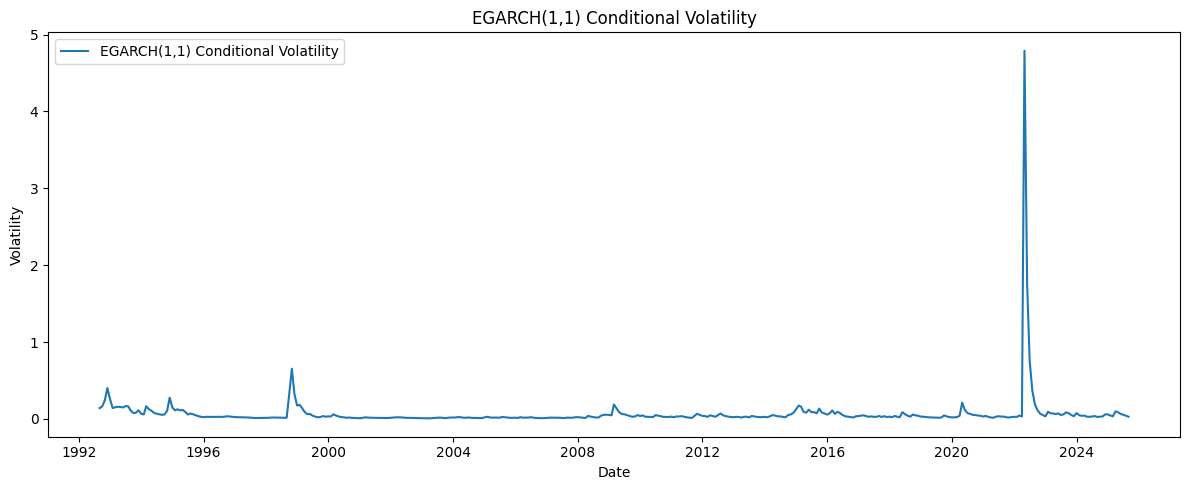

In [77]:
# A quick plot for EGARCH(1,1)
plt.figure(figsize=(12, 5))
plt.plot(egarch_fit.conditional_volatility, label='EGARCH(1,1) Conditional Volatility')
plt.title('EGARCH(1,1) Conditional Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()

### V. Combine SARIMAX + GARCH: A Joint Predictive Framework

In this section, I will build a two-step model that captures both the macro-driven structure in the RUB/USD exchange rate and the time-varying uncertainty in its volatility.

Why Combine Them?

* SARIMAX captures economic structure (mean equation)
* GARCH captures market dynamics and shocks (variance equation)

Together, they provide:
* Point forecasts (where RUB/USD is going)
* orecast uncertainty (how confident we are)
* More realistic intervals for decision-making

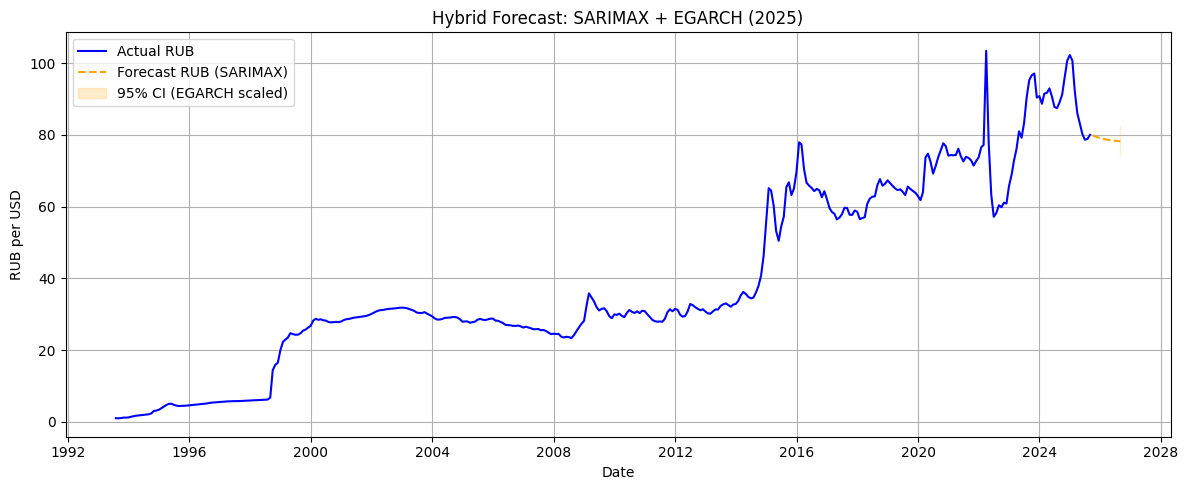

In [78]:
# Step 1: Prepare data
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita_lag12']
data_model = data_lagged.dropna(subset=[target] + exog_vars).copy()

log_y = np.log(data_model[target])
X = data_model[exog_vars]

# Step 2: Fit SARIMAX (Model 7)
model7 = SARIMAX(log_y, exog=X, order=(2, 1, 2), enforce_stationarity=False, enforce_invertibility=False)
model7_fit = model7.fit(disp=False)

# Step 3: Forecast log(RUB) for 2025
forecast_index = pd.date_range(start=log_y.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')
exog_future = pd.DataFrame([X.iloc[-1].values] * 12, columns=X.columns, index=forecast_index)
sarimax_forecast = model7_fit.get_forecast(steps=12, exog=exog_future)
sarimax_log_mean = sarimax_forecast.predicted_mean
sarimax_mean = np.exp(sarimax_log_mean)

# Step 4: Fit EGARCH on residuals from log-SARIMAX
resid7 = model7_fit.resid
egarch_model = arch_model(resid7, vol='EGARCH', p=1, q=1, dist='normal')
egarch_fit = egarch_model.fit(disp='off')

# Step 5: Forecast volatility for 2025
vol_forecast = egarch_fit.forecast(horizon=1, reindex=True)
vol_std_1step = np.sqrt(vol_forecast.variance.iloc[-12:])
if hasattr(vol_std_1step, "values") and vol_std_1step.shape[1] == 1:
    vol_std_1step = vol_std_1step.iloc[:, 0]

# Step 6: Create CI bands (convert from log-space to RUB)
upper = np.exp(sarimax_log_mean + 1.96 * vol_std_1step.values)
lower = np.exp(sarimax_log_mean - 1.96 * vol_std_1step.values)

# Step 7: Plot
plt.figure(figsize=(12, 5))
plt.plot(log_y.index, np.exp(log_y), label='Actual RUB', color='blue')
plt.plot(forecast_index, sarimax_mean, label='Forecast RUB (SARIMAX)', color='orange', linestyle='--')
plt.fill_between(forecast_index, lower, upper, color='orange', alpha=0.2, label='95% CI (EGARCH scaled)')
plt.title('Hybrid Forecast: SARIMAX + EGARCH (2025)')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

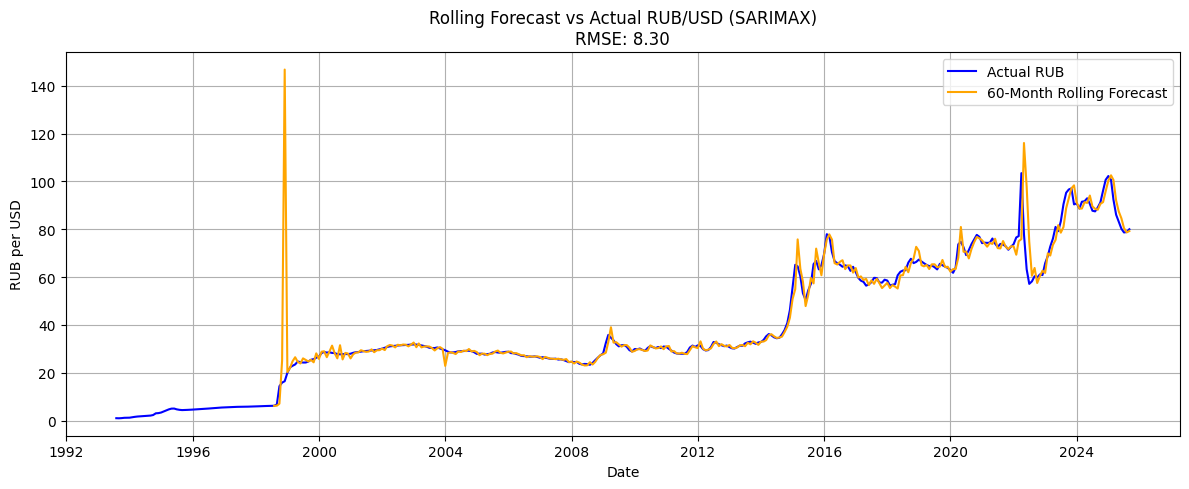

In [79]:

# Step 1: Prepare data
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita_lag12']
data_model = data_lagged.dropna(subset=[target] + exog_vars).copy()

log_y = np.log(data_model[target])
X = data_model[exog_vars]

# Step 2: Rolling Forecast with SARIMAX (60-month window)
window_size = 60
preds = []
actuals = []
forecast_dates = []

for i in range(window_size, len(log_y)):
    y_train = log_y.iloc[i - window_size:i]
    X_train = X.iloc[i - window_size:i]
    y_test_actual = np.exp(log_y.iloc[i])  # Convert back from log
    X_test = X.iloc[i:i+1]

    model = SARIMAX(
        y_train,
        exog=X_train,
        order=(2, 1, 2),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    forecast_log = result.get_forecast(steps=1, exog=X_test)
    forecast = np.exp(forecast_log.predicted_mean.iloc[0])
    preds.append(forecast)
    actuals.append(y_test_actual)
    forecast_dates.append(log_y.index[i])

# Step 3: Plot results
pred_series = pd.Series(preds, index=forecast_dates)
actual_series = pd.Series(actuals, index=forecast_dates)
rmse = np.sqrt(mean_squared_error(actual_series, pred_series))

plt.figure(figsize=(12, 5))
plt.plot(data_model.index, data_model[target], label='Actual RUB', color='blue')
plt.plot(pred_series.index, pred_series, label='60-Month Rolling Forecast', color='orange')
plt.title(f'Rolling Forecast vs Actual RUB/USD (SARIMAX)\nRMSE: {rmse:.2f}')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

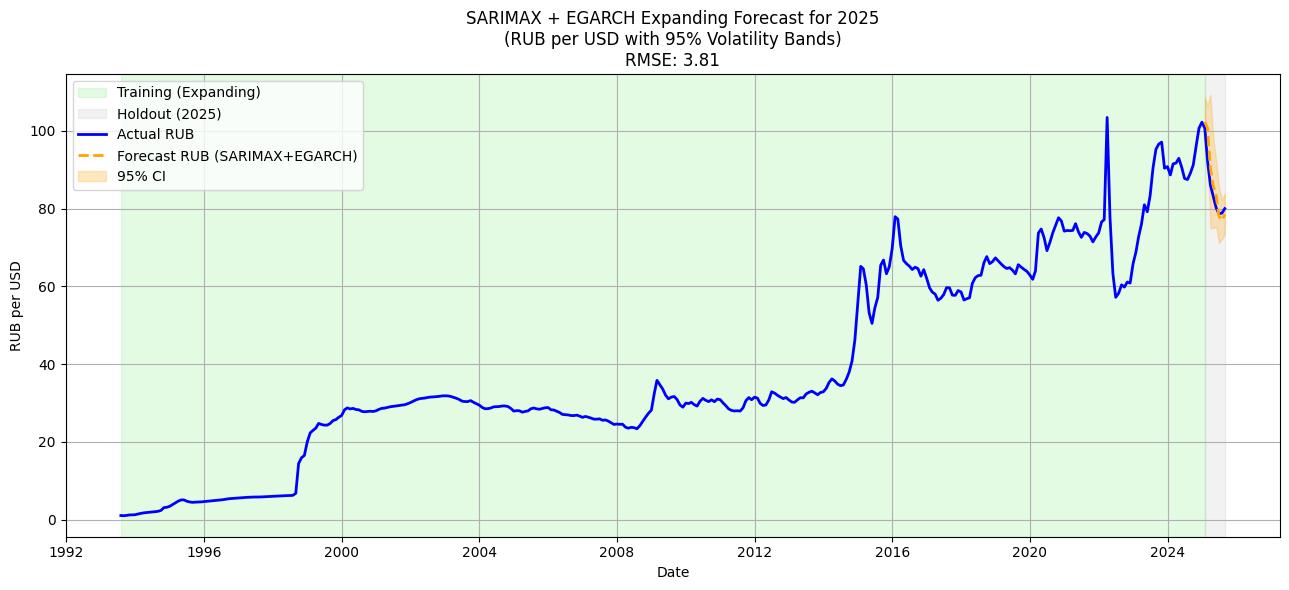

In [80]:

# === Step 1: Data Preparation ===
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita_lag12']
data_model = data_lagged.dropna(subset=[target] + exog_vars).copy()
log_y_full = np.log(data_model[target])
X_full = data_model[exog_vars]

# === Step 2: Setup expanding window forecasting for 2025 ===
holdout_start = '2025-01-31'
holdout_end = '2025-12-31'
holdout_dates = data_model.loc[holdout_start:holdout_end].index

preds, actuals, upper_ci, lower_ci = [], [], [], []

for date in holdout_dates:
    test_idx = data_model.index.get_loc(date)
    
    # expanding window
    y_train = log_y_full.iloc[:test_idx]
    X_train = X_full.iloc[:test_idx]
    
    y_test = data_model[target].iloc[test_idx]
    X_test = X_full.iloc[test_idx:test_idx+1]

    # === SARIMAX model ===
    model = SARIMAX(y_train, exog=X_train, order=(2,1,2), 
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    
    # forecast log(RUB)
    forecast_log = model_fit.get_forecast(steps=1, exog=X_test)
    pred_log = forecast_log.predicted_mean.iloc[0]
    
    # === EGARCH on SARIMAX residuals ===
    resid = model_fit.resid
    garch = arch_model(resid, vol='EGARCH', p=1, q=1, dist='normal')
    garch_fit = garch.fit(disp='off')
    vol_pred = np.sqrt(garch_fit.forecast(horizon=1).variance.iloc[-1, 0])
    
    # convert to level + CI
    pred = np.exp(pred_log)
    upper = np.exp(pred_log + 1.96 * vol_pred)
    lower = np.exp(pred_log - 1.96 * vol_pred)

    preds.append(pred)
    actuals.append(y_test)
    upper_ci.append(upper)
    lower_ci.append(lower)

# === Step 3: Calculate RMSE ===
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(actuals, preds))

# === Step 4: Plot results ===
forecast_index = holdout_dates[:len(preds)]
history_index = log_y_full.index

plt.figure(figsize=(13, 6))

# Highlight training region (light green) for all training periods
plt.axvspan(history_index[0], forecast_index[0], color='lightgreen', alpha=0.25, label='Training (Expanding)')

# Highlight holdout region (gray)
plt.axvspan(forecast_index[0], forecast_index[-1], color='gray', alpha=0.1, label='Holdout (2025)')

# Full actuals (historical, including 2025)
plt.plot(history_index, np.exp(log_y_full), color='blue', label='Actual RUB', linewidth=2)

# Forecast
plt.plot(forecast_index, preds, label='Forecast RUB (SARIMAX+EGARCH)', color='orange', linestyle='--', linewidth=2)
plt.fill_between(forecast_index, lower_ci, upper_ci, color='orange', alpha=0.25, label='95% CI')

plt.title(f'SARIMAX + EGARCH Expanding Forecast for 2025\n(RUB per USD with 95% Volatility Bands)\nRMSE: {rmse:.2f}')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

RMSE: 3.60


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


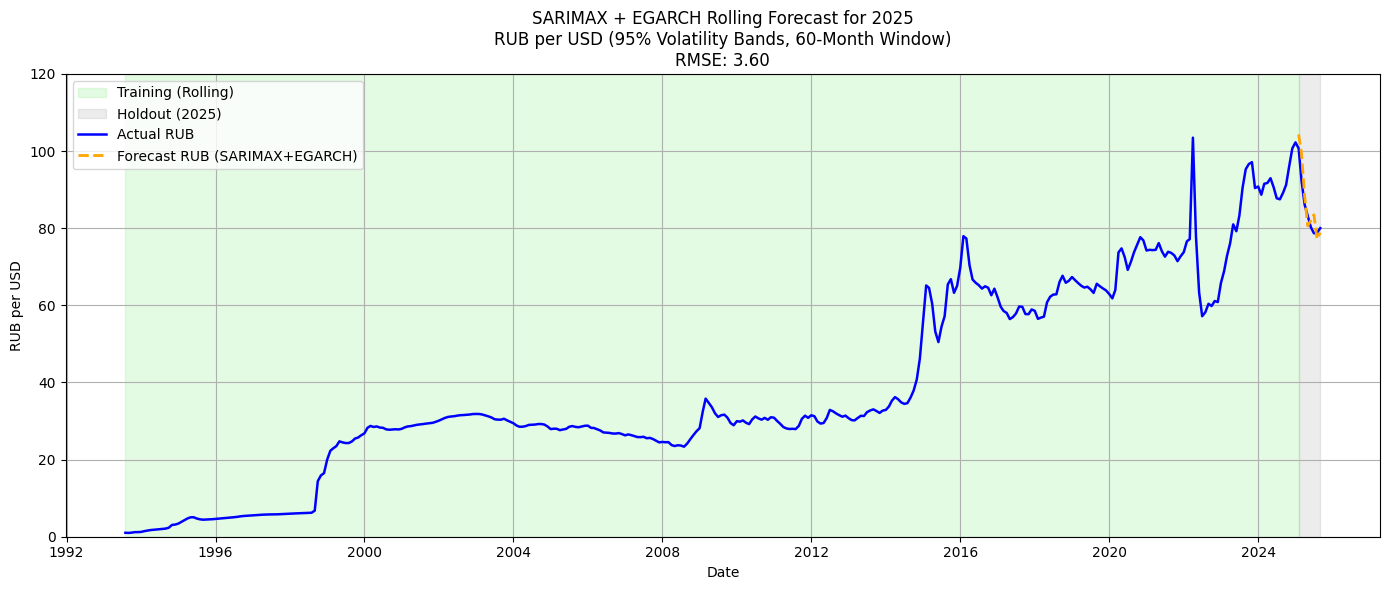

In [81]:
# === Step 1: Prepare data ===
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita_lag12']
data_model = data_lagged.dropna(subset=[target] + exog_vars).copy()

log_y_full = np.log(data_model[target])
X_full = data_model[exog_vars]

# === Step 2: Set up 2025 holdout ===
holdout_start = '2025-01-31'
holdout_end = '2025-12-31'
holdout_dates = data_model.loc[holdout_start:holdout_end].index

# === Step 3: Rolling window setup ===
window_size = 24  # last 5 years of data
preds, actuals, upper_ci, lower_ci = [], [], [], []

for date in holdout_dates:
    test_idx = data_model.index.get_loc(date)
    if test_idx < window_size:
        continue  # skip if not enough history

    y_train = log_y_full.iloc[test_idx - window_size:test_idx]
    X_train = X_full.iloc[test_idx - window_size:test_idx]
    y_test = data_model[target].iloc[test_idx]
    X_test = X_full.iloc[test_idx:test_idx+1]

    # === Fit SARIMAX ===
    model = SARIMAX(y_train, exog=X_train, order=(2,1,2),
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    # Forecast log(RUB)
    forecast_log = model_fit.get_forecast(steps=1, exog=X_test)
    pred_log = forecast_log.predicted_mean.iloc[0]

    # === EGARCH on residuals ===
    resid = model_fit.resid
    garch = arch_model(resid, vol='EGARCH', p=1, q=1, dist='normal')
    garch_fit = garch.fit(disp='off')

    vol_pred = np.sqrt(garch_fit.forecast(horizon=1).variance.iloc[-1, 0])

    # Convert back to level + CI
    pred = np.exp(pred_log)
    upper = np.exp(pred_log + 1.96 * vol_pred)
    lower = np.exp(pred_log - 1.96 * vol_pred)

    preds.append(pred)
    actuals.append(y_test)
    upper_ci.append(upper)
    lower_ci.append(lower)

# === Step 4: Calculate RMSE ===
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(actuals, preds))
print(f"RMSE: {rmse:.2f}")

# === Step 5: Clip insane CI values for visibility ===
upper_ci = np.clip(upper_ci, a_min=None, a_max=500)  # clip at 500 RUB/USD

# === Step 6: Plot ===
forecast_index = holdout_dates[:len(preds)]
history_index = log_y_full.index

plt.figure(figsize=(14, 6))

# Highlight training region (green)
plt.axvspan(history_index[0], forecast_index[0], color='lightgreen', alpha=0.25, label='Training (Rolling)')
# Highlight holdout region (gray)
plt.axvspan(forecast_index[0], forecast_index[-1], color='gray', alpha=0.15, label='Holdout (2025)')

# Actual & predicted values
plt.plot(history_index, np.exp(log_y_full), color='blue', label='Actual RUB', linewidth=1.8)
plt.plot(forecast_index, preds, label='Forecast RUB (SARIMAX+EGARCH)', color='orange', linestyle='--', linewidth=2)
#plt.fill_between(forecast_index, lower_ci, upper_ci, color='orange', alpha=0.25, label='95% CI (EGARCH)')

plt.title(f'SARIMAX + EGARCH Rolling Forecast for 2025\nRUB per USD (95% Volatility Bands, 60-Month Window)\nRMSE: {rmse:.2f}')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.ylim(0, 120)  # Set Y-axis limits from 0 to 140
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()